In [8]:
import numpy as np
import pandas as pd
import os
import scipy.io
import ieeg_funcs as ief
import re
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
import imp 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline

path_dict=ief.get_path_dict()
path_dict['ieeg_root']

'/Users/davidgroppe/ONGOING/TWH_EEG/'

In [ ]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

In [3]:
# Define sub and onset channel
#sub='TF'
sub='NA'
onset_df=pd.read_csv('/Users/davidgroppe/PycharmProjects/SZR_ANT/chans_of_interest.csv',na_filter=False)
row_id=onset_df[onset_df.iloc[:,0]==sub].index.tolist()
onset_chan=onset_df.iloc[row_id[0],1].strip() #strip removes white space
print('Sub=%s, onset chan=%s' % (sub,onset_chan))

Sub=NA, onset chan=RHD1-2


In [4]:
# Import Clinician Szr Onset Times
if sys.platform=='linux':
    onset_csv_dir='/home/dgroppe/TWH_INFO/CLINICIAN_ONSET_TIMES'
else:
    onset_csv_dir='/Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES'
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinician_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

Importing file /Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES/NA_clinician_onset_offset.csv


In [5]:
onset_df.head()

,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT,DG_ONSET_CHAN,USE4CLASSIFIER
0,1,1,8:59:03 PM,9:38:35 PM,?,?,06/23/2009,500,?,75543,NaN,NaN,?,noEEGdata
1,1,2,1:54:41 AM,1:55:52 AM,RHD1,1:52:45,06/23/2009,500,?,6881,6765.0,58000.0,RHD1-2,use
2,1,3,2:42:25 AM,2:43:58 AM,?,2:39:36,06/23/2009,500,?,9745,9576.0,84500.0,RHD1-2,use
3,1,4,4:51:59 AM,4:53:35 AM,?,4:49:03,06/23/2009,500,?,17519,17343.0,88000.0,RHD1-2,use
4,1,5,6:29:14 AM,6:31:11 AM,?,6:26:20,06/23/2009,500,?,23354,23180.0,87000.0,RHD1-2,use


In [6]:
# Get list of channels and ID of onset channel
chan_labels=ief.import_chan_labels(sub)
onset_chan_id=chan_labels.index(onset_chan)

Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/NA_channel_info.csv


In [10]:
# Load manual onset times (this is just to get list of usable seizure names)
csv_path='/Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/'+sub+'/ONSETTIMES/'
print('Importing manual onset times from %s' % csv_path)
csv_list=list()
for f in os.listdir(csv_path):
    if f.endswith('manualOnsets.txt'):
        csv_list.append(f)

n_files=len(csv_list)
print('%d manual wide-band onset files found' % n_files)

Importing manual onset times from /Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/NA/ONSETTIMES/
7 manual wide-band onset files found


NA_d1_sz2
Getting clinical onset time for NA: Day 1, Szr 2
Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/EEG_MAT/NA_d1_sz2.mat
201 dimensions
1860 observations


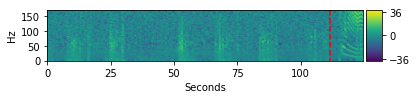

In [44]:
imp.reload(ief) 
n_chan=len(chan_labels)

# Loop through manual files (since I have one for each mat file)
#for man_file_loop in range(n_files): TODO use this!!!
for man_file_loop in range(1):
    szr_name=csv_list[man_file_loop].split('_manualOnsets')[0]
    #     digit_substrings=re.findall(r'\d+',csv_list[man_file_loop])
    #     szr_day=int(digit_substrings[0])
    #     szr_num=int(digit_substrings[1])

    # See if I have a clinician onset
    print(szr_name)
    # ?? onset_tpt=ief.clin_onset_tpt(szr_name, onset_df)
    onset_tpt, onset_chan=ief.clin_onset_tpt_and_chan(szr_name, onset_df)
    
    if onset_tpt<0:
        print('Warning: %s has a clinician onset time that is earlier than the file start time.' % szr_name)
        print('Ignoring this szr for the time being')
        onset_tpt=np.nan
    elif np.isnan(onset_tpt):
        print('Warning: %s has no clinician onset time.'  % szr_name)
        print('Ignoring this szr for the time being')
    else:
        # Load the ieeg data
        ieeg, Sf, tpts_sec=ief.import_ieeg(szr_name+'.mat')
        
        # Calcuate onset window (there is uncertainty due second resolution of Xltek text files)
        onset_upper_bnd_sec=(onset_tpt/Sf)+1
        onset_lower_bnd_sec=(onset_tpt/Sf)-1
    
        # Plot voltage time series at just the onset channel
#         plt.figure(2)
#         plt.clf()
#         plt.plot(tpts_sec,ieeg[onset_chan_id,:])
#         plt.xlim([onset_lower_bnd_sec-5, onset_upper_bnd_sec+3])
#         ax=plt.gca()
#         ylim=ax.get_ylim()
#         plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'r--')
#         plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'r--')
#         plt.xlabel('Seconds')
#         plt.ylabel('Voltage')
        #plt.title(szr_name+' '+chan_labels[onset_chan_id])
    
        # Compute spectrogram at onset channel
        wind_len=Sf
        wind_step=Sf/10
        n_tapers=4
        sgram, f, sgram_sec=ief.mt_sgram(ieeg[onset_chan_id,:],Sf,wind_len,wind_step,n_tapers,tpts_sec)
        cutoff_freq=Sf*.4 # remove frequencies above anti-aliasing filter cutoff
        f=f[f<=cutoff_freq]
        n_freq=len(f)
        sgram=sgram[:n_freq,:]
        n_wind=len(sgram_sec)
    
        # Find target stimulation window
        clinician_onset_in_sec=tpts_sec[int(onset_tpt)]
        stim_onset_tpt=dg.find_nearest(sgram_sec, clinician_onset_in_sec-4)
        stim_offset_tpt=dg.find_nearest(sgram_sec, clinician_onset_in_sec+9)
        
        # Plot sgram at just onset channel with onset overlay
        plt.figure(3)
        plt.clf()
        ax = plt.gca()
        # 40% Trimmed normalization
        dg.trimmed_normalize(sgram,.4)
        #plt.imshow(sgram)
        abs_mx=np.max(np.abs(sgram))
        im=ax.imshow(sgram,vmin=-abs_mx,vmax=abs_mx)
        onset_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec)
        onset_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec)
        ylim=plt.ylim()
#         plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
#         plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
        plt.plot([stim_onset_tpt, stim_onset_tpt],ylim,'r--')
        #plt.plot([stim_offset_tpt, stim_offset_tpt],ylim,'r--')
        raw_xticks=plt.xticks()
        xtick_labels=list()
        for tick in raw_xticks[0]:
            if tick<n_wind:
                xtick_labels.append(str(int(sgram_sec[int(tick)])))
            else:
                xtick_labels.append('noData')
        _=plt.xticks(raw_xticks[0],xtick_labels) #works
        plt.ylim(ylim)
        #plt.xlim([0,n_wind])
        plt.xlim([0,stim_offset_tpt])
        plt.ylabel('Hz')
        plt.xlabel('Seconds')
        plt.gca().invert_yaxis()
        ytick_labels=list()
        yticks=np.arange(0,201,50)
        for tick in yticks:
                ytick_labels.append(str(int(f[tick])))
        _=plt.yticks(np.arange(0,201,59),ytick_labels)
        #plt.title(szr_name+' '+chan_labels[onset_chan_id]+' '+'Sgram (40% trim norm dB)')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar_max_tick=int(np.floor(abs_mx*.95))
        cbar_min_tick=-cbar_max_tick
        cbar=plt.colorbar(im, cax=cax,ticks=[cbar_min_tick, 0, cbar_max_tick])
        plt.savefig('example_szr_sgram.pdf')

In [49]:
# Load a feature
bro=np.load('/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/VLTGSTD_3SEC/IB/IB_d6_sz3_vltg_std3sec.npz')
bro.keys()

['peri_ictal', 'time_wind_sec', 'ftr_list', 'ftrs']

In [48]:
np.max(bro['time_wind_sec'][bro['peri_ictal']==0])

197.899

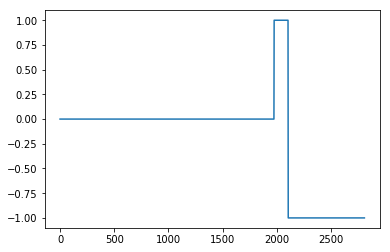

In [47]:
plt.figure(1)
plt.clf()
plt.plot(bro['peri_ictal'])

In [ ]:
# Load Raw Data

# Load Features

Plo